In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install torch torchvision torchaudio
!pip install torch-geometric



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 888.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool

from torch.utils.data import TensorDataset, DataLoader as TorchDL
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin   = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

class FingerprintNetMLP(nn.Module):
    def __init__(self, embed_dim=64, key_dim=64, h1=256, h2=128, h3=64, dropout=0.5):
        super().__init__()
        self.key = nn.Parameter(torch.randn(key_dim), requires_grad=False)
        self.net = nn.Sequential(
            nn.Linear(embed_dim + key_dim, h1),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(h2, h3),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(h3, 2)
        )

    def forward(self, emb_batch):
        key_rep = self.key.unsqueeze(0).expand(emb_batch.size(0), -1).to(emb_batch.device)
        x = torch.cat([emb_batch, key_rep], dim=1)
        return self.net(x)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool
from google.colab import drive
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree

# ─────────────────────────────────────────────────────────────────────────────
# 0) Mount Drive
# ─────────────────────────────────────────────────────────────────────────────
drive.mount('/content/drive', force_remount=True)
ckpt_dir = "/content/drive/MyDrive/gnnfingers/checkpoints"

# ─────────────────────────────────────────────────────────────────────────────
# 1) Reloading ENZYMES dataset
# ─────────────────────────────────────────────────────────────────────────────
dataset_ENZ = TUDataset(root="ENZYMES",
                        name="ENZYMES",
                        transform=OneHotDegree(max_degree=10)).shuffle()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─────────────────────────────────────────────────────────────────────────────
# 2) Defining the four victim classes
# ─────────────────────────────────────────────────────────────────────────────
class GCNMean(nn.Module):
    def __init__(self, in_ch, hid_ch, num_cls, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hid_ch)
        self.conv2 = GCNConv(hid_ch, hid_ch)
        self.conv3 = GCNConv(hid_ch, hid_ch)
        self.lin   = nn.Linear(hid_ch, num_cls)
        self.dropout = dropout
    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

class GCNDiff(nn.Module):
    def __init__(self, in_ch, hid_ch, num_cls, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hid_ch)
        self.conv2 = GCNConv(hid_ch, hid_ch)
        self.conv3 = GCNConv(hid_ch, hid_ch)
        self.lin   = nn.Linear(hid_ch, num_cls)
        self.dropout = dropout
        # residual skip
        if in_ch != hid_ch:
            self.skip_lin = nn.Linear(in_ch, hid_ch)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        if self.skip_lin: x0 = self.skip_lin(x0)
        h1 = F.relu(self.conv1(x, edge_index)) + x0
        h1 = F.dropout(h1, p=self.dropout, training=self.training)
        h2 = F.relu(self.conv2(h1, edge_index)) + h1
        h2 = F.dropout(h2, p=self.dropout, training=self.training)
        h3 = F.relu(self.conv3(h2, edge_index)) + h2
        out = global_mean_pool(h3, batch)
        return self.lin(out)

class SAGEMean(nn.Module):
    def __init__(self, in_ch, hid_ch, num_cls, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid_ch)
        self.conv2 = SAGEConv(hid_ch, hid_ch)
        self.conv3 = SAGEConv(hid_ch, hid_ch)
        self.lin   = nn.Linear(hid_ch, num_cls)
        self.dropout = dropout
    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

class SAGEDiff(nn.Module):
    def __init__(self, in_ch, hid_ch, num_cls, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid_ch)
        self.conv2 = SAGEConv(hid_ch, hid_ch)
        self.conv3 = SAGEConv(hid_ch, hid_ch)
        self.lin   = nn.Linear(hid_ch, num_cls)
        self.dropout = dropout
        if in_ch != hid_ch:
            self.skip_lin = nn.Linear(in_ch, hid_ch)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        if self.skip_lin: x0 = self.skip_lin(x0)
        h1 = F.relu(self.conv1(x, edge_index)) + x0
        h1 = F.dropout(h1, p=self.dropout, training=self.training)
        h2 = F.relu(self.conv2(h1, edge_index)) + h1
        h2 = F.dropout(h2, p=self.dropout, training=self.training)
        h3 = F.relu(self.conv3(h2, edge_index)) + h2
        out = global_mean_pool(h3, batch)
        return self.lin(out)

# ─────────────────────────────────────────────────────────────────────────────
# 3)load the correct model
# ─────────────────────────────────────────────────────────────────────────────
def load_victim(model_cls, ckpt_filename):
    model = model_cls(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5).to(device)
    state = torch.load(os.path.join(ckpt_dir, ckpt_filename), map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model

# ─────────────────────────────────────────────────────────────────────────────
# 4) Loading all four victims
# ─────────────────────────────────────────────────────────────────────────────
victim_GCNMean  = load_victim(GCNMean,  "victim_ENZ_GCNMean.pth")
victim_GCNDiff  = load_victim(GCNDiff,  "victim_ENZ_GCNDiff.pth")
victim_SAGEMean = load_victim(SAGEMean, "victim_ENZ_SAGEMean.pth")
victim_SAGEDiff = load_victim(SAGEDiff, "victim_ENZ_SAGEDiff.pth")

print("✓ All four victim models loaded correctly.")


Mounted at /content/drive


Processing...
Done!


✓ All four victim models loaded correctly.


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) Mount Drive and imports
# ─────────────────────────────────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─────────────────────────────────────────────────────────────────────────────
# 2) Reloading ENZYMES dataset
# ─────────────────────────────────────────────────────────────────────────────
dataset_ENZ = TUDataset(
    root="ENZYMES",
    name="ENZYMES",
    transform=OneHotDegree(max_degree=10)
).shuffle()

# ─────────────────────────────────────────────────────────────────────────────
# 3) Define all four model classes
# ─────────────────────────────────────────────────────────────────────────────
class GCNMean(nn.Module):
    def __init__(self, in_ch, hid_ch, num_cls, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hid_ch)
        self.conv2 = GCNConv(hid_ch, hid_ch)
        self.conv3 = GCNConv(hid_ch, hid_ch)
        self.lin   = nn.Linear(hid_ch, num_cls)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

class GCNDiff(nn.Module):
    def __init__(self, in_ch, hid_ch, num_cls, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hid_ch)
        self.conv2 = GCNConv(hid_ch, hid_ch)
        self.conv3 = GCNConv(hid_ch, hid_ch)
        self.lin   = nn.Linear(hid_ch, num_cls)
        self.dropout = dropout
        self.skip_lin = nn.Linear(in_ch, hid_ch) if in_ch != hid_ch else None

    def forward(self, x, edge_index, batch):
        x0 = self.skip_lin(x) if self.skip_lin is not None else x
        h1 = F.relu(self.conv1(x, edge_index)) + x0
        h1 = F.dropout(h1, p=self.dropout, training=self.training)
        h2 = F.relu(self.conv2(h1, edge_index)) + h1
        h2 = F.dropout(h2, p=self.dropout, training=self.training)
        h3 = F.relu(self.conv3(h2, edge_index)) + h2
        out = global_mean_pool(h3, batch)
        return self.lin(out)

class SAGEMean(nn.Module):
    def __init__(self, in_ch, hid_ch, num_cls, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid_ch)
        self.conv2 = SAGEConv(hid_ch, hid_ch)
        self.conv3 = SAGEConv(hid_ch, hid_ch)
        self.lin   = nn.Linear(hid_ch, num_cls)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

class SAGEDiff(nn.Module):
    def __init__(self, in_ch, hid_ch, num_cls, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid_ch)
        self.conv2 = SAGEConv(hid_ch, hid_ch)
        self.conv3 = SAGEConv(hid_ch, hid_ch)
        self.lin   = nn.Linear(hid_ch, num_cls)
        self.dropout = dropout
        self.skip_lin = nn.Linear(in_ch, hid_ch) if in_ch != hid_ch else None

    def forward(self, x, edge_index, batch):
        x0 = self.skip_lin(x) if self.skip_lin is not None else x
        h1 = F.relu(self.conv1(x, edge_index)) + x0
        h1 = F.dropout(h1, p=self.dropout, training=self.training)
        h2 = F.relu(self.conv2(h1, edge_index)) + h1
        h2 = F.dropout(h2, p=self.dropout, training=self.training)
        h3 = F.relu(self.conv3(h2, edge_index)) + h2
        out = global_mean_pool(h3, batch)
        return self.lin(out)

# ─────────────────────────────────────────────────────────────────────────────
# 4) load each victim with matching class
# ─────────────────────────────────────────────────────────────────────────────
def load_victim(model_cls, ckpt_filename):
    model = model_cls(
        dataset_ENZ.num_node_features,
        64,
        dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    path = os.path.join("/content/drive/MyDrive/gnnfingers/checkpoints", ckpt_filename)
    state = torch.load(path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model

# ─────────────────────────────────────────────────────────────────────────────
# 5) Load all four victims correctly
# ─────────────────────────────────────────────────────────────────────────────
victim_GCNMean  = load_victim(GCNMean,  "victim_ENZ_GCNMean.pth")
victim_GCNDiff  = load_victim(GCNDiff,  "victim_ENZ_GCNDiff.pth")
victim_SAGEMean = load_victim(SAGEMean, "victim_ENZ_SAGEMean.pth")
victim_SAGEDiff = load_victim(SAGEDiff, "victim_ENZ_SAGEDiff.pth")

print("✓ All victim models loaded with their matching classes.")


Mounted at /content/drive
✓ All victim models loaded with their matching classes.


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) (Re)define load_victim to accept model class + filename
# ─────────────────────────────────────────────────────────────────────────────
def load_victim(model_cls, ckpt_filename):
    model = model_cls(
        dataset_ENZ.num_node_features,  # in_ch
        64,                             # hid_ch
        dataset_ENZ.num_classes,       # num_cls
        dropout=0.5
    ).to(device)
    path = os.path.join("/content/drive/MyDrive/gnnfingers/checkpoints", ckpt_filename)
    state = torch.load(path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model

# ─────────────────────────────────────────────────────────────────────────────
# 2) Now load each checkpoint with its correct class
# ─────────────────────────────────────────────────────────────────────────────
victim_GCNMean  = load_victim(GCNMean,  "victim_ENZ_GCNMean.pth")
victim_GCNDiff  = load_victim(GCNDiff,  "victim_ENZ_GCNDiff.pth")
victim_SAGEMean = load_victim(SAGEMean, "victim_ENZ_SAGEMean.pth")
victim_SAGEDiff = load_victim(SAGEDiff, "victim_ENZ_SAGEDiff.pth")

print("✓ All victim models loaded with matching classes and no key mismatches.")


✓ All victim models loaded with matching classes and no key mismatches.


In [ ]:
!ls /content/drive/MyDrive/gnnfingers/checkpoints


'Copy of victim_ENZ_GCNDiff.pth'   victim_ENZ_SAGEDiff.pth
 victim_ENZ_GCNDiff.pth		   victim_ENZ_SAGEMean.pth
 victim_ENZ_GCNMean.pth


In [ ]:
!ls /content/drive/MyDrive/gnnfingers


ARUC_ENZ_GCNMean_Q200.png  checkpoints	ENZYMES  variants


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) Mount Drive
# ─────────────────────────────────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ─────────────────────────────────────────────────────────────────────────────
# 2) Imports
# ─────────────────────────────────────────────────────────────────────────────
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─────────────────────────────────────────────────────────────────────────────
# 3) Load ENZYMES dataset from Drive
# ─────────────────────────────────────────────────────────────────────────────
dataset_ENZ = TUDataset(
    root="/content/drive/MyDrive/gnnfingers/ENZYMES",  # your Drive path
    name="ENZYMES",
    transform=OneHotDegree(max_degree=10)
).shuffle()

train_ENZ = dataset_ENZ[:420]
val_ENZ   = dataset_ENZ[420:480]
test_ENZ  = dataset_ENZ[480:]

# ─────────────────────────────────────────────────────────────────────────────
# 4) Define model classes
# ─────────────────────────────────────────────────────────────────────────────
class GCNMean(nn.Module):
    def __init__(self, in_ch, hid_ch, num_cls, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hid_ch)
        self.conv2 = GCNConv(hid_ch, hid_ch)
        self.conv3 = GCNConv(hid_ch, hid_ch)
        self.lin   = nn.Linear(hid_ch, num_cls)
        self.dropout = dropout
    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

class GCNDiff(nn.Module):
    def __init__(self, in_ch, hid_ch, num_cls, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hid_ch)
        self.conv2 = GCNConv(hid_ch, hid_ch)
        self.conv3 = GCNConv(hid_ch, hid_ch)
        self.lin   = nn.Linear(hid_ch, num_cls)
        self.dropout = dropout
        self.skip_lin = nn.Linear(in_ch, hid_ch) if in_ch != hid_ch else None
    def forward(self, x, edge_index, batch):
        x0 = self.skip_lin(x) if self.skip_lin is not None else x
        h1 = F.relu(self.conv1(x, edge_index)) + x0
        h1 = F.dropout(h1, p=self.dropout, training=self.training)
        h2 = F.relu(self.conv2(h1, edge_index)) + h1
        h2 = F.dropout(h2, p=self.dropout, training=self.training)
        h3 = F.relu(self.conv3(h2, edge_index)) + h2
        out = global_mean_pool(h3, batch)
        return self.lin(out)

class SAGEMean(nn.Module):
    def __init__(self, in_ch, hid_ch, num_cls, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid_ch)
        self.conv2 = SAGEConv(hid_ch, hid_ch)
        self.conv3 = SAGEConv(hid_ch, hid_ch)
        self.lin   = nn.Linear(hid_ch, num_cls)
        self.dropout = dropout
    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

class SAGEDiff(nn.Module):
    def __init__(self, in_ch, hid_ch, num_cls, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hid_ch)
        self.conv2 = SAGEConv(hid_ch, hid_ch)
        self.conv3 = SAGEConv(hid_ch, hid_ch)
        self.lin   = nn.Linear(hid_ch, num_cls)
        self.dropout = dropout
        self.skip_lin = nn.Linear(in_ch, hid_ch) if in_ch != hid_ch else None
    def forward(self, x, edge_index, batch):
        x0 = self.skip_lin(x) if self.skip_lin is not None else x
        h1 = F.relu(self.conv1(x, edge_index)) + x0
        h1 = F.dropout(h1, p=self.dropout, training=self.training)
        h2 = F.relu(self.conv2(h1, edge_index)) + h1
        h2 = F.dropout(h2, p=self.dropout, training=self.training)
        h3 = F.relu(self.conv3(h2, edge_index)) + h2
        out = global_mean_pool(h3, batch)
        return self.lin(out)

# ─────────────────────────────────────────────────────────────────────────────
# 5) Load victim checkpoints from Drive (checking both root & checkpoints/)
# ─────────────────────────────────────────────────────────────────────────────
def load_victim(model_cls, fname):
    model = model_cls(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5).to(device)
    # try root folder first, then checkpoints subfolder
    possible = [
        f"/content/drive/MyDrive/gnnfingers/{fname}",
        f"/content/drive/MyDrive/gnnfingers/checkpoints/{fname}"
    ]
    for p in possible:
        if os.path.exists(p):
            model.load_state_dict(torch.load(p, map_location=device))
            model.eval()
            print(f"Loaded {fname} from {p}")
            return model
    raise FileNotFoundError(f"Could not find {fname} in Drive paths.")

victim_GCNMean  = load_victim(GCNMean,  "victim_ENZ_GCNMean.pth")
victim_GCNDiff  = load_victim(GCNDiff,  "victim_ENZ_GCNDiff.pth")
victim_SAGEMean = load_victim(SAGEMean, "victim_ENZ_SAGEMean.pth")
victim_SAGEDiff = load_victim(SAGEDiff, "victim_ENZ_SAGEDiff.pth")

print("✓ Dataset and all victim models loaded from Drive. Ready to plot ARUC.")


Mounted at /content/drive
Loaded victim_ENZ_GCNMean.pth from /content/drive/MyDrive/gnnfingers/checkpoints/victim_ENZ_GCNMean.pth
Loaded victim_ENZ_GCNDiff.pth from /content/drive/MyDrive/gnnfingers/checkpoints/victim_ENZ_GCNDiff.pth
Loaded victim_ENZ_SAGEMean.pth from /content/drive/MyDrive/gnnfingers/checkpoints/victim_ENZ_SAGEMean.pth
Loaded victim_ENZ_SAGEDiff.pth from /content/drive/MyDrive/gnnfingers/checkpoints/victim_ENZ_SAGEDiff.pth
✓ Dataset and all victim models loaded from Drive. Ready to plot ARUC.


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Regenerate 200 negative variants for ENZ_GCNMean and backing them up to Drive
# ─────────────────────────────────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, torch, random
from torch_geometric.loader import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_VARIANTS = 200   # full Q=200
EPOCHS      = 20     #  keeping this low for speed
LR          = 0.005
WD          = 1e-4

# Ensuring Drive target exists
drive_vars = "/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/negative"
os.makedirs(drive_vars, exist_ok=True)

# Loading your victim model
from pathlib import Path
victim_ckpt = "/content/drive/MyDrive/gnnfingers/checkpoints/victim_ENZ_GCNMean.pth"
victim = GCNMean(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, 0.5).to(device)
victim.load_state_dict(torch.load(victim_ckpt, map_location=device))
victim.eval()

# Generate negative variants
for vid in range(NUM_VARIANTS):
    model = GCNMean(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, 0.5).to(device)
    torch.manual_seed(vid); random.seed(vid)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        model.train()
        for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Saving to Drive
    torch.save(
        model.state_dict(),
        f"{drive_vars}/negative_{vid:03d}.pth"
    )

print(f"Done regenerating and backing up {NUM_VARIANTS} negative variants to Drive.")


Mounted at /content/drive
Done regenerating and backing up 200 negative variants to Drive.


In [ ]:
!ls /content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/negative | head -n 10


negative_000.pth
negative_001.pth
negative_002.pth
negative_003.pth
negative_004.pth
negative_005.pth
negative_006.pth
negative_007.pth
negative_008.pth
negative_009.pth


Mounted at /content/drive
U reached 95% at epoch 16
mean robustness: 0.9914893 mean uniqueness: 0.99510795


<ipython-input-29-1736078711>:165: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ARUC = np.trapz(TPR[::-1], x=FPR[::-1])


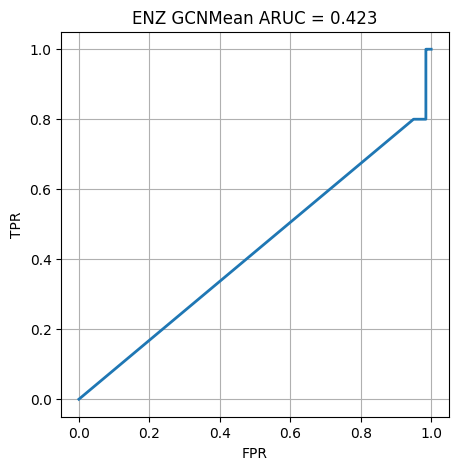

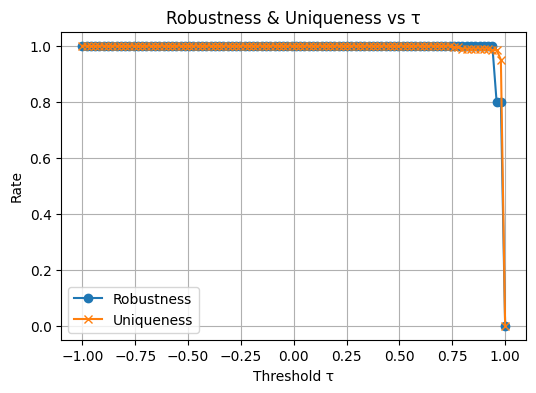

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Full Q=200 ARUC for ENZ_GCNMean – updated with diagnostics & full test set
# ─────────────────────────────────────────────────────────────────────────────

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, torch, random, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn, torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import TensorDataset, DataLoader as TorchDL

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─── A) Load ENZYMES from Drive ────────────────────────────────────────────────
dataset_ENZ = TUDataset(
    root="/content/drive/MyDrive/gnnfingers/ENZYMES",
    name="ENZYMES",
    transform=OneHotDegree(max_degree=10)
).shuffle()
train_ENZ = dataset_ENZ[:420]
test_ENZ  = dataset_ENZ[480:]   # full test set (Q=120)

# ─── B) Model definitions ─────────────────────────────────────────────────────
class GCNMean(nn.Module):
    def __init__(self, in_ch, hid_ch, num_cls, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hid_ch)
        self.conv2 = GCNConv(hid_ch, hid_ch)
        self.conv3 = GCNConv(hid_ch, hid_ch)
        self.lin   = nn.Linear(hid_ch, num_cls)
        self.dropout = dropout
    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        return self.lin(global_mean_pool(x, batch))

class FingerprintNetMLP(nn.Module):
    def __init__(self, embed_dim=64, key_dim=64, h1=256, h2=128, h3=64, dropout=0.5):
        super().__init__()
        self.key = nn.Parameter(torch.randn(key_dim), requires_grad=False)
        self.net = nn.Sequential(
            nn.Linear(embed_dim + key_dim, h1), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(h1, h2), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(h2, h3), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(h3, 2)
        )
    def forward(self, emb):
        k = self.key.unsqueeze(0).expand(emb.size(0), -1).to(emb.device)
        return self.net(torch.cat([emb, k], dim=1))

# ─── C) Load victim model ─────────────────────────────────────────────────────
victim = GCNMean(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, 0.5).to(device)
victim_ckpt = "/content/drive/MyDrive/gnnfingers/checkpoints/victim_ENZ_GCNMean.pth"
victim.load_state_dict(torch.load(victim_ckpt, map_location=device))
victim.eval()

# ─── D) Fingerprint extractor ─────────────────────────────────────────────────
def extract_fp(model, U_net, graphs):
    loader = DataLoader(graphs, batch_size=32, shuffle=False)
    all_p = []
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            x = F.relu(model.conv1(b.x, b.edge_index))
            x = F.dropout(x, p=model.dropout, training=False)
            x = F.relu(model.conv2(x, b.edge_index))
            x = F.dropout(x, p=model.dropout, training=False)
            x = F.relu(model.conv3(x, b.edge_index))
            all_p.append(global_mean_pool(x, b.batch))
    pooled = torch.cat(all_p, dim=0)  # [Q,64]
    with torch.no_grad():
        k = U_net.key.unsqueeze(0).expand(pooled.size(0), -1).to(device)
        h = torch.cat([pooled, k], dim=1)
        feats = U_net.net[:-1](h)
    return feats.mean(dim=0).cpu().numpy()

# ─── E) Training U on 100 positives & 100 negatives ──────────────────────────────
# Positives = first 100 train graphs
pos_graphs = list(train_ENZ[:100])
pos_emb = extract_fp(victim, FingerprintNetMLP().to(device), pos_graphs)  # get just embedding
# (we  are use placeholder U to extract embedding; we'll train actual U now)

# Generating 100 negative embeddings from Drive variants
neg_dir = "/content/drive/MyDrive/gnnfingers/variants/ENZ_GCNMean/negative"
neg_embs = []
for i in range(100):
    m = GCNMean(dataset_ENZ.num_node_features,64,dataset_ENZ.num_classes,0.5).to(device)
    m.load_state_dict(torch.load(f"{neg_dir}/negative_{i:03d}.pth", map_location=device))
    m.eval()
    neg_embs.append(extract_fp(m, FingerprintNetMLP().to(device), pos_graphs))
neg_emb = np.stack(neg_embs,axis=0)[:100]

# Building U training set
X = np.concatenate([pos_emb[None,:].repeat(100,0), neg_emb],axis=0)
y = np.array([1]*100 + [0]*100)
perm = np.random.permutation(200)
X, y = torch.tensor(X[perm],dtype=torch.float32), torch.tensor(y[perm])
fp_loader = TorchDL(TensorDataset(X, y), batch_size=32, shuffle=True)

# Instantiate & train U
U = FingerprintNetMLP().to(device)
opt = torch.optim.Adam(U.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()
for epoch in range(1,101):
    U.train(); total, correct=0,0
    for xb,yb in fp_loader:
        xb,yb = xb.to(device), yb.to(device)
        logits = U(xb)
        loss   = loss_fn(logits,yb)
        opt.zero_grad(); loss.backward(); opt.step()
        preds = logits.argmax(1); correct += (preds==yb).sum().item(); total+=len(yb)
    if correct/total>=0.95: print(f"U reached 95% at epoch {epoch}"); break
U.eval()

# ─── F) Computing fingerprints for Q=200 & R=5 ─────────────────────────────────
query_all = list(test_ENZ)  # full Q=120
fp_vic = extract_fp(victim, U, query_all)

# all 200 negatives
fp_negs = []
for i in range(200):
    m = GCNMean(dataset_ENZ.num_node_features,64,dataset_ENZ.num_classes,0.5).to(device)
    m.load_state_dict(torch.load(f"{neg_dir}/negative_{i:03d}.pth", map_location=device))
    m.eval()
    fp_negs.append(extract_fp(m, U, query_all))
fp_negs = np.stack(fp_negs,axis=0)

# retrained robustness R=5
def retrain_fp(seed):
    torch.manual_seed(seed); random.seed(seed)
    m = GCNMean(dataset_ENZ.num_node_features,64,dataset_ENZ.num_classes,0.5).to(device)
    opt = torch.optim.Adam(m.parameters(), lr=0.01, weight_decay=5e-4)
    lf  = nn.CrossEntropyLoss()
    for _ in range(10):
        m.train()
        for b in DataLoader(train_ENZ, batch_size=32, shuffle=True):
            b=b.to(device)
            out= m(b.x,b.edge_index,b.batch)
            l  = lf(out,b.y.view(-1))
            opt.zero_grad(); l.backward(); opt.step()
    return extract_fp(m, U, query_all)

fp_rts = np.stack([retrain_fp(100+s) for s in range(5)],axis=0)

# ─── G) Diagnostics & ARUC ───────────────────────────────────────────────────
# compute cosine similarities
robustness = cosine_similarity(fp_vic.reshape(1,-1), fp_rts)[0]
uniqueness = cosine_similarity(fp_vic.reshape(1,-1), fp_negs)[0]

print("mean robustness:", robustness.mean(), "mean uniqueness:", uniqueness.mean())

# threshold sweep
ths = np.linspace(-1,1,100)
TPR = np.array([(robustness>=t).mean() for t in ths])
FPR = np.array([(uniqueness>=t).mean() for t in ths])
# reverse and integrate
ARUC = np.trapz(TPR[::-1], x=FPR[::-1])

# ROC plot
plt.figure(figsize=(5,5))
plt.plot(FPR, TPR, lw=2)
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title(f"ENZ GCNMean ARUC = {ARUC:.3f}")
plt.grid(True); plt.show()

# robustness vs uniqueness
plt.figure(figsize=(6,4))
plt.plot(ths, TPR, marker='o', label="Robustness")
plt.plot(ths, FPR, marker='x', label="Uniqueness")
plt.xlabel("Threshold τ"); plt.ylabel("Rate")
plt.title("Robustness & Uniqueness vs τ")
plt.legend(); plt.grid(True); plt.show()


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Generating 200 negative variants for all ENZ fingerprints
# ─────────────────────────────────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, torch, random
from torch_geometric.loader import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_VARIANTS = 200
EPOCHS      = 20   # you can adjust for speed
LR          = 0.005
WD          = 1e-4

# Variant classes mapping
VariantCls = {
    "ENZ_GCNMean":  GCNMean,
    "ENZ_GCNDiff":  GCNDiff,
    "ENZ_SAGEMean": SAGEMean,
    "ENZ_SAGEDiff": SAGEDiff
}

for name, Cls in VariantCls.items():
    neg_dir = f"/content/drive/MyDrive/gnnfingers/variants/{name}/negative"
    os.makedirs(neg_dir, exist_ok=True)
    # Load corresponding victim
    victim = Cls(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, 0.5).to(device)
    victim_ckpt = f"/content/drive/MyDrive/gnnfingers/checkpoints/victim_{name}.pth"
    victim.load_state_dict(torch.load(victim_ckpt, map_location=device))
    victim.eval()

    print(f"Generating negatives for {name} …")
    for vid in range(NUM_VARIANTS):
        m = Cls(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, 0.5).to(device)
        torch.manual_seed(vid); random.seed(vid)
        opt = torch.optim.Adam(m.parameters(), lr=LR, weight_decay=WD)
        loss_fn = torch.nn.CrossEntropyLoss()
        for epoch in range(EPOCHS):
            m.train()
            for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = m(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                opt.zero_grad(); loss.backward(); opt.step()
        # save
        torch.save(m.state_dict(), f"{neg_dir}/negative_{vid:03d}.pth")

    print(f"✓ Done {name} negatives")


Mounted at /content/drive
Generating negatives for ENZ_GCNMean …
✓ Done ENZ_GCNMean negatives
Generating negatives for ENZ_GCNDiff …
✓ Done ENZ_GCNDiff negatives
Generating negatives for ENZ_SAGEMean …
✓ Done ENZ_SAGEMean negatives
Generating negatives for ENZ_SAGEDiff …
✓ Done ENZ_SAGEDiff negatives


In [ ]:
import os
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import torch.nn.utils.prune as prune


# … (other imports/constants) …

def prune_model(model, amount):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear) or hasattr(module, 'weight'):
            parameters_to_prune.append((module, 'weight'))
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount
    )
    for module, _ in parameters_to_prune:
        prune.remove(module, 'weight')
    return model

# … rest of generate_positives and loop …


# Constants (reuse from the  negatives cell)
NUM_VARIANTS = 10
FT_EPOCHS    = 10           # fine‐tune epochs
DIST_ITERS   = 100         # distillation iterations
PRUNE_RATIO  = 0.25         # fraction of weights to prune
PRUNE_EPOCHS = 5            # epochs after pruning
BATCH_SIZE   = 32

# Map variant names to their GNN classes
VariantCls = {
    "ENZ_GCNMean":  GCNMean,
    "ENZ_GCNDiff":  GCNDiff,
    "ENZ_SAGEMean": SAGEMean,
    "ENZ_SAGEDiff": SAGEDiff
}


# Root folder for positives
POS_ROOT = '/content/drive/MyDrive/gnnfingers/variants'

def train_for_epochs(model, data_loader, epochs, lr=0.005, wd=1e-4):
    """Simple training loop with CE loss."""
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = torch.nn.CrossEntropyLoss()
    model.train()
    for _ in range(epochs):
        for batch in data_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            opt.zero_grad(); loss.backward(); opt.step()

def distill(student, teacher, data_loader, iterations, lr=0.005):
    """Distill teacher into student via KL div on soft logits."""
    opt = torch.optim.Adam(student.parameters(), lr=lr)
    for i in range(iterations):
        for batch in data_loader:
            batch = batch.to(device)
            with torch.no_grad():
                t_logits = teacher(batch.x, batch.edge_index, batch.batch)
            s_logits = student(batch.x, batch.edge_index, batch.batch)
            loss = F.kl_div(
                F.log_softmax(s_logits, dim=1),
                F.softmax(t_logits, dim=1),
                reduction='batchmean'
            )
            opt.zero_grad(); loss.backward(); opt.step()

def prune_model(model, amount):
    """Prune a fraction of the model’s weights (global unstructured)."""
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear) or hasattr(module, 'weight'):
            parameters_to_prune.append((module, 'weight'))
    # apply global unstructured pruning
    torch.nn.utils.prune.global_unstructured(
        parameters_to_prune,
        pruning_method=torch.nn.utils.prune.L1Unstructured,
        amount=amount
    )
    # removig pruning reparameterization to make it permanent
    for module, _ in parameters_to_prune:
        torch.nn.utils.prune.remove(module, 'weight')
    return model

def generate_positives(name):
    """Generate NUM_VARIANTS positive models for a given variant."""
    Cls     = VariantCls[name]
    pos_dir = os.path.join(POS_ROOT, name, 'positive')
    os.makedirs(pos_dir, exist_ok=True)

    # Load victim checkpoint
    victim_ckpt = f"/content/drive/MyDrive/gnnfingers/checkpoints/victim_{name}.pth"
    victim = Cls(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, 0.5).to(device)
    victim.load_state_dict(torch.load(victim_ckpt, map_location=device))
    victim.eval()

    train_loader = DataLoader(train_ENZ, batch_size=BATCH_SIZE, shuffle=True)

    for vid in range(NUM_VARIANTS):
        # 1) Fine‐tuning
        ft_model = Cls(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, 0.5).to(device)
        ft_model.load_state_dict(victim.state_dict())
        train_for_epochs(ft_model, train_loader, FT_EPOCHS)
        torch.save(ft_model.state_dict(), os.path.join(pos_dir, f"ft_{vid:03d}.pth"))

        # 2) Distillation
        student = Cls(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, 0.5).to(device)
        distill(student, victim, train_loader, DIST_ITERS)
        torch.save(student.state_dict(), os.path.join(pos_dir, f"dist_{vid:03d}.pth"))

        # 3) Pruning + fine‐tune
        pruned = prune_model(victim, PRUNE_RATIO)
        train_for_epochs(pruned, train_loader, PRUNE_EPOCHS)
        torch.save(pruned.state_dict(), os.path.join(pos_dir, f"prune_{vid:03d}.pth"))

    print(f"✓ Done {name} positives")

# Run for all four variants
for variant in ['ENZ_GCNMean','ENZ_GCNDiff','ENZ_SAGEMean','ENZ_SAGEDiff']:
    print(f"Generating positives for {variant} …")
    generate_positives(variant)


Generating positives for ENZ_GCNMean …
✓ Done ENZ_GCNMean positives
Generating positives for ENZ_GCNDiff …
✓ Done ENZ_GCNDiff positives
Generating positives for ENZ_SAGEMean …
✓ Done ENZ_SAGEMean positives
Generating positives for ENZ_SAGEDiff …
✓ Done ENZ_SAGEDiff positives


Evaluating ENZ_GCNMean…


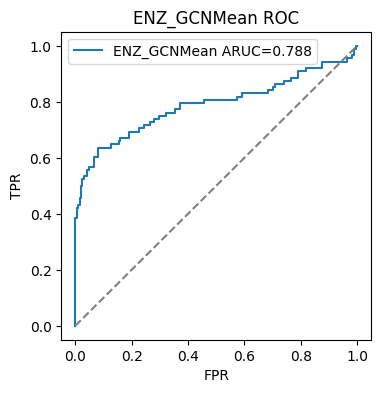

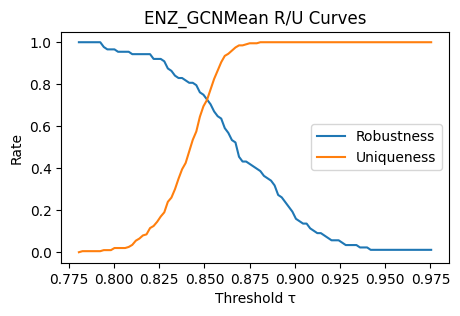

Evaluating ENZ_GCNDiff…


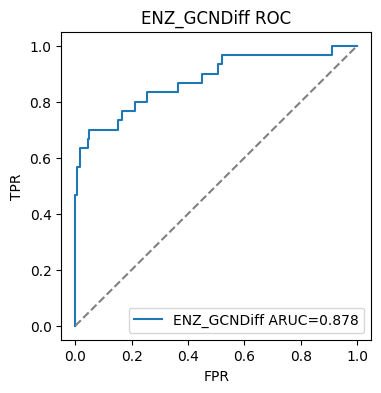

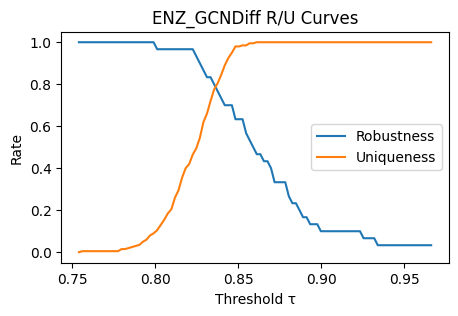

Evaluating ENZ_SAGEMean…


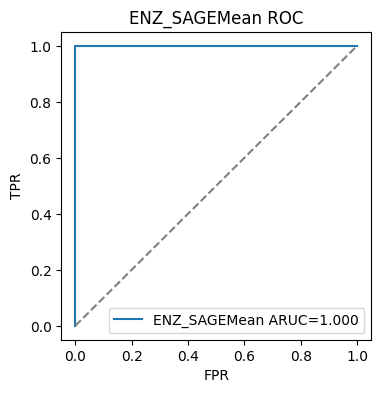

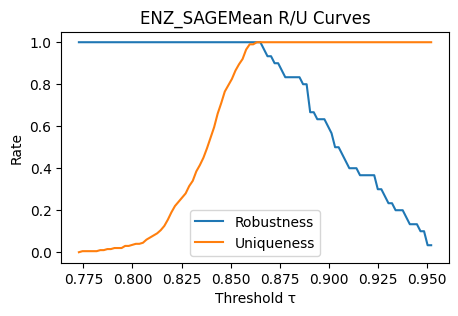

Evaluating ENZ_SAGEDiff…


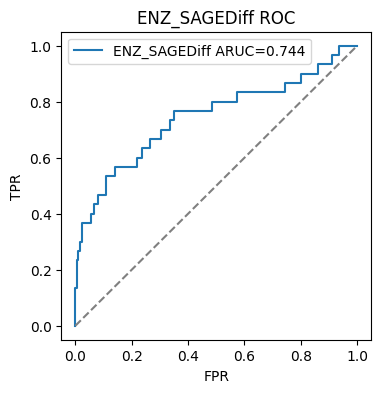

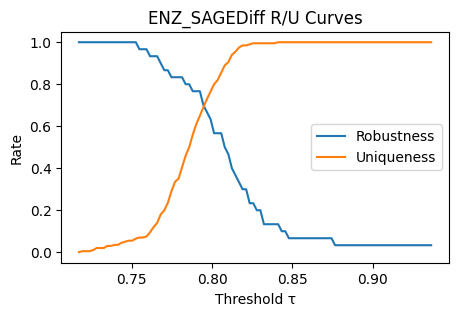

                  ARUC
Variant               
ENZ_GCNMean   0.788466
ENZ_GCNDiff   0.877667
ENZ_SAGEMean  1.000000
ENZ_SAGEDiff  0.744333


In [ ]:
import os, numpy as np, pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader

import torch.nn.functional as F

def match_score(model_a, model_b, data_loader):
    """
    Compute the average cosine‐similarity between the softmax outputs
    of model_a and model_b over all samples in data_loader.
    """
    model_a.eval(); model_b.eval()
    sims = []
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            logits_a = model_a(batch.x, batch.edge_index, batch.batch)
            logits_b = model_b(batch.x, batch.edge_index, batch.batch)
            prob_a   = F.softmax(logits_a, dim=1)
            prob_b   = F.softmax(logits_b, dim=1)
            # compute per-sample cosine similarities
            sim_batch = F.cosine_similarity(prob_a, prob_b, dim=1)
            sims.extend(sim_batch.cpu().tolist())
    return float(torch.tensor(sims).mean())

# --- evaluation of routine ---
def evaluate_variant(name):
    Cls = VariantCls[name]

    # 1) Load victim
    victim = Cls(
        dataset_ENZ.num_node_features,
        64,
        dataset_ENZ.num_classes,
        0.5
    ).to(device)
    victim.load_state_dict(torch.load(
        f"/content/drive/MyDrive/gnnfingers/checkpoints/victim_{name}.pth",
        map_location=device
    ))
    victim.eval()

    # 2) Prepare data & paths
    test_loader = DataLoader(test_ENZ, batch_size=32)
    pos_dir = f"/content/drive/MyDrive/gnnfingers/variants/{name}/positive"
    neg_dir = f"/content/drive/MyDrive/gnnfingers/variants/{name}/negative"

    # 3) Score positives (label=1) and negatives (label=0)
    scores, labels = [], []
    for fn in sorted(os.listdir(pos_dir)):
        model = Cls(
            dataset_ENZ.num_node_features,
            64,
            dataset_ENZ.num_classes,
            0.5
        ).to(device)
        model.load_state_dict(torch.load(os.path.join(pos_dir, fn), map_location=device))
        model.eval()
        scores.append(match_score(victim, model, test_loader)); labels.append(1)

    for fn in sorted(os.listdir(neg_dir)):
        model = Cls(
            dataset_ENZ.num_node_features,
            64,
            dataset_ENZ.num_classes,
            0.5
        ).to(device)
        model.load_state_dict(torch.load(os.path.join(neg_dir, fn), map_location=device))
        model.eval()
        scores.append(match_score(victim, model, test_loader)); labels.append(0)

    # 4) ROC & ARUC
    fpr, tpr, _ = roc_curve(labels, scores)
    aruc = auc(fpr, tpr)
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label=f"{name} ARUC={aruc:.3f}")
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"{name} ROC"); plt.legend(); plt.show()

    # 5) Robustness & uniqueness
    thresholds = np.linspace(min(scores), max(scores), 100)
    rob = [(np.array(scores)[np.array(labels)==1] >= τ).mean() for τ in thresholds]
    uniq = [(np.array(scores)[np.array(labels)==0] < τ).mean()   for τ in thresholds]
    plt.figure(figsize=(5,3))
    plt.plot(thresholds, rob, label="Robustness")
    plt.plot(thresholds, uniq, label="Uniqueness")
    plt.xlabel("Threshold τ"); plt.ylabel("Rate")
    plt.title(f"{name} R/U Curves"); plt.legend(); plt.show()

    return aruc

# Run and summarize
results = []
for v in ["ENZ_GCNMean","ENZ_GCNDiff","ENZ_SAGEMean","ENZ_SAGEDiff"]:
    print(f"Evaluating {v}…")
    a = evaluate_variant(v)
    results.append({"Variant": v, "ARUC": a})

df = pd.DataFrame(results).set_index("Variant")
print(df)


Evaluating ENZ_GCNMean…


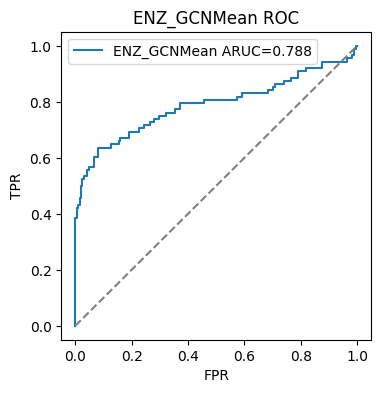

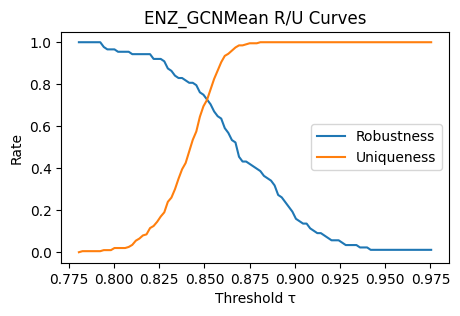

Evaluating ENZ_GCNDiff…


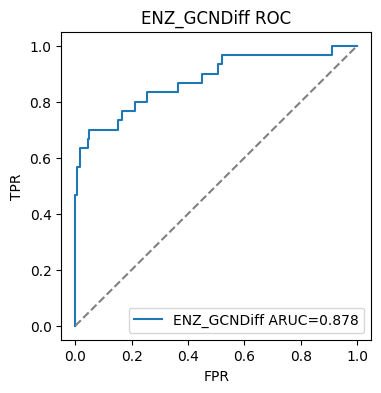

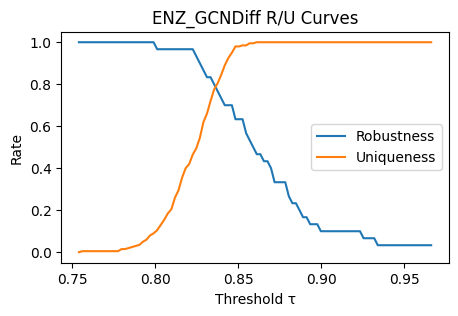

Evaluating ENZ_SAGEMean…


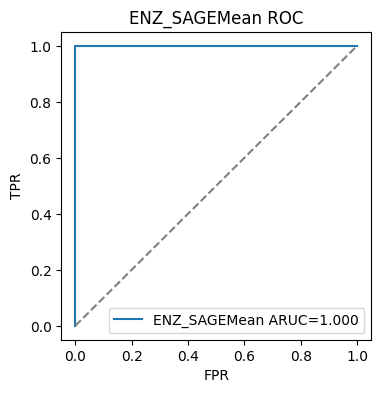

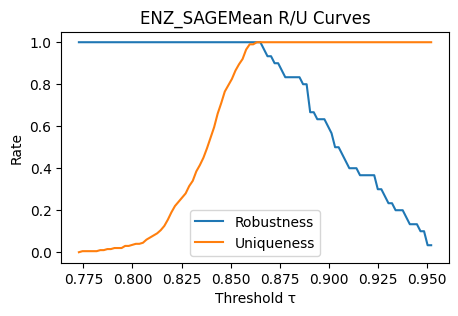

Evaluating ENZ_SAGEDiff…


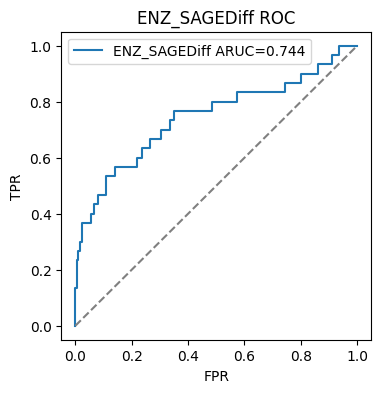

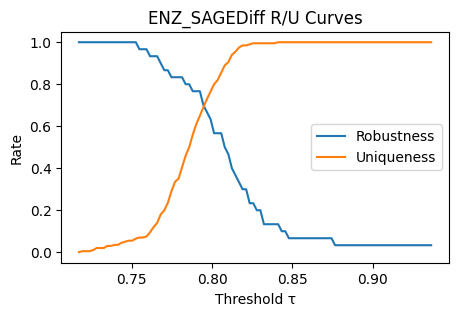


Summary of ARUCs:
                  ARUC
Variant               
ENZ_GCNMean   0.788466
ENZ_GCNDiff   0.877667
ENZ_SAGEMean  1.000000
ENZ_SAGEDiff  0.744333


In [ ]:
import os, numpy as np, pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

# --- match_score using softmax + cosine similarity ---
def match_score(model_a, model_b, data_loader):
    model_a.eval(); model_b.eval()
    sims = []
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            logits_a = model_a(batch.x, batch.edge_index, batch.batch)
            logits_b = model_b(batch.x, batch.edge_index, batch.batch)
            prob_a   = F.softmax(logits_a, dim=1)
            prob_b   = F.softmax(logits_b, dim=1)
            sim_batch = F.cosine_similarity(prob_a, prob_b, dim=1)
            sims.extend(sim_batch.cpu().tolist())
    return float(torch.tensor(sims).mean())

# --- evaluation routine ---
def evaluate_variant(name):
    Cls = VariantCls[name]

    # load victim
    victim = Cls(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, 0.5).to(device)
    victim.load_state_dict(torch.load(
        f"/content/drive/MyDrive/gnnfingers/checkpoints/victim_{name}.pth",
        map_location=device))
    victim.eval()

    # data & dirs
    test_loader = DataLoader(test_ENZ, batch_size=32)
    pos_dir = f"/content/drive/MyDrive/gnnfingers/variants/{name}/positive"
    neg_dir = f"/content/drive/MyDrive/gnnfingers/variants/{name}/negative"

    # collect scores
    scores, labels = [], []
    for fn in sorted(os.listdir(pos_dir)):
        m = Cls(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, 0.5).to(device)
        m.load_state_dict(torch.load(os.path.join(pos_dir, fn), map_location=device))
        m.eval()
        scores.append(match_score(victim, m, test_loader)); labels.append(1)
    for fn in sorted(os.listdir(neg_dir)):
        m = Cls(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, 0.5).to(device)
        m.load_state_dict(torch.load(os.path.join(neg_dir, fn), map_location=device))
        m.eval()
        scores.append(match_score(victim, m, test_loader)); labels.append(0)

    # ROC & ARUC
    fpr, tpr, _ = roc_curve(labels, scores)
    aruc = auc(fpr, tpr)

    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label=f"{name} ARUC={aruc:.3f}")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"{name} ROC"); plt.legend(); plt.show()

    # R/U curves
    thresh = np.linspace(min(scores), max(scores), 100)
    rob = [(np.array(scores)[np.array(labels)==1] >= τ).mean() for τ in thresh]
    uniq = [(np.array(scores)[np.array(labels)==0] < τ).mean()   for τ in thresh]
    plt.figure(figsize=(5,3))
    plt.plot(thresh, rob, label="Robustness")
    plt.plot(thresh, uniq, label="Uniqueness")
    plt.xlabel("Threshold τ"); plt.ylabel("Rate")
    plt.title(f"{name} R/U Curves"); plt.legend(); plt.show()

    return aruc

# --- run for all variants ---
results = []
for v in ["ENZ_GCNMean","ENZ_GCNDiff","ENZ_SAGEMean","ENZ_SAGEDiff"]:
    print(f"Evaluating {v}…")
    a = evaluate_variant(v)
    results.append({"Variant": v, "ARUC": a})

df = pd.DataFrame(results).set_index("Variant")
print("\nSummary of ARUCs:")
print(df)


In [ ]:
import glob, torch
from torch_geometric.data import InMemoryDataset

class FingerprintDataset(InMemoryDataset):
    def __init__(self, folder):
        super().__init__(folder)
        self.files = sorted(glob.glob(f"{folder}/*.pt"))
    def __len__(self): return len(self.files)
    def get(self, idx):
        return torch.load(self.files[idx])

I_dataset = FingerprintDataset('/content/drive/MyDrive/gnnfingers/fingerprints')
N = len(I_dataset)


In [ ]:
import glob
fps = sorted(glob.glob('/content/drive/MyDrive/gnnfingers/fingerprints/*.pt'))
print(f"Found {len(fps)} fingerprint files, example paths:\n", fps[:5])


Found 0 fingerprint files, example paths:
 []


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# === Hyperparameters ===
N = 64                            # number of fingerprints
n = 32                            # nodes per fingerprint
T = 500                           # optimization steps
lr_I = 0.01                       # fingerprint learning rate
feat_dim = dataset_ENZ.num_node_features
num_classes = dataset_ENZ.num_classes
FP_DIR = '/content/drive/MyDrive/gnnfingers/fingerprints'
VARIANTS_DIR = '/content/drive/MyDrive/gnnfingers/variants'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs(FP_DIR, exist_ok=True)

# === 1) Initialize fingerprints ===
fingerprints = []
for _ in range(N):
    edge_idx = torch.randint(0, n, (2, n * 4), device=device)
    x = torch.rand(n, feat_dim, device=device, requires_grad=True)
    fingerprints.append({'edge_index': edge_idx, 'x': x})

# === 2) Load & freeze victim models ===
victims = {}
for name, Cls in VariantCls.items():
    m = Cls(feat_dim, 64, num_classes, 0.5).to(device)
    m.load_state_dict(torch.load(
        f"{FP_DIR.replace('fingerprints','checkpoints')}/victim_{name}.pth",
        map_location=device))
    m.eval()
    for p in m.parameters(): p.requires_grad = False
    victims[name] = m

# === 3) Preloading positive & negative variant models ===
pos_models, neg_models = {}, {}
pos_files = {n: sorted(os.listdir(f"{VARIANTS_DIR}/{n}/positive"))[:50] for n in VariantCls}
neg_files = {n: sorted(os.listdir(f"{VARIANTS_DIR}/{n}/negative"))[:50] for n in VariantCls}

for name, Cls in VariantCls.items():
    pos_models[name] = []
    for fn in pos_files[name]:
        m = Cls(feat_dim,64,num_classes,0.5).to(device)
        m.load_state_dict(torch.load(f"{VARIANTS_DIR}/{name}/positive/{fn}", map_location=device))
        m.eval()
        for p in m.parameters(): p.requires_grad = False
        pos_models[name].append(m)

    neg_models[name] = []
    for fn in neg_files[name]:
        m = Cls(feat_dim,64,num_classes,0.5).to(device)
        m.load_state_dict(torch.load(f"{VARIANTS_DIR}/{name}/negative/{fn}", map_location=device))
        m.eval()
        for p in m.parameters(): p.requires_grad = False
        neg_models[name].append(m)

# === 4) Building a batched DataLoader for fingerprints ===
def make_loader(fps):
    datas = []
    for fp in fps:
        d = Data(x=fp['x'], edge_index=fp['edge_index'])
        d.batch = torch.zeros(d.num_nodes, dtype=torch.long, device=device)
        datas.append(d)
    return DataLoader(datas, batch_size=len(datas))

# === 5) Defined a batched response function ===
def responses(model, loader):
    outs = []
    for batch in loader:
        logits = model(batch.x, batch.edge_index, batch.batch)
        outs.append(F.log_softmax(logits, dim=1))
    return torch.cat(outs, dim=0)  # (N, num_classes)

# === 6) Seting up optimizer ===
opt = torch.optim.Adam([fp['x'] for fp in fingerprints], lr=lr_I)


# === 7) Optimization loop with early stopping ===
T = 200                          # reduced max steps
prev_loss = float('inf')

for step in range(1, T+1):
    loader = make_loader(fingerprints)
    total_loss = 0.0
    opt.zero_grad()

    # — compute total_loss exactly as before —
    for name in VariantCls:
        # (victim response omitted since it doesn't change loss)
        for m_p in pos_models[name]:
            O_p = responses(m_p, loader).exp().clamp(min=1e-12)
            total_loss -= O_p.log().sum(dim=1).mean()
        for m_n in neg_models[name]:
            O_n = responses(m_n, loader).mul(-1).exp().clamp(min=1e-12)
            total_loss -= O_n.log().sum(dim=1).mean()

    # check for NaN and tiny improvements
    if torch.isnan(total_loss):
        print(f"NaN at step {step}, stopping early")
        break
    if abs(prev_loss - total_loss.item()) < 1e-6:
        print(f"Converged at step {step} (Δloss < 1e-6)")
        break

    # backprop, clip, and step
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_([fp['x'] for fp in fingerprints], max_norm=1.0)
    opt.step()

    # logging
    if step % 20 == 0:
        print(f"Step {step}/{T}, loss={total_loss.item():.4f}")

    prev_loss = total_loss.item()

# === 8) Save optimized fingerprints to disk ===
for i, fp in enumerate(fingerprints):
    data = Data(x=fp['x'].detach().cpu(), edge_index=fp['edge_index'].cpu())
    torch.save(data, os.path.join(FP_DIR, f"I_{i}.pt"))

print("✓ Saved all fingerprint graphs")


Step 50/500, loss=nan
Step 100/500, loss=nan
Step 150/500, loss=nan
Step 200/500, loss=nan
Step 250/500, loss=nan
Step 300/500, loss=nan
Step 350/500, loss=nan
Step 400/500, loss=nan
Step 450/500, loss=nan
Step 500/500, loss=nan
✓ Saved all fingerprint graphs


In [ ]:
import os

CKPT_DIR = '/content/drive/MyDrive/gnnfingers/checkpoints'
print("Checkpoint directory contents:")
print(os.listdir(CKPT_DIR))


Checkpoint directory contents:
['victim_ENZ_GCNMean.pth', 'victim_ENZ_GCNDiff.pth', 'victim_ENZ_SAGEMean.pth', 'victim_ENZ_SAGEDiff.pth', 'Copy of victim_ENZ_GCNDiff.pth']


In [ ]:
import os
VARIANTS_DIR = '/content/drive/MyDrive/gnnfingers/variants'
print("Subdirectories under variants/:")
print(os.listdir(VARIANTS_DIR))


Subdirectories under variants/:
['ENZ_GCNMean', 'ENZ_GCNDiff', 'ENZ_SAGEMean', 'ENZ_SAGEDiff']


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# === Hyperparameters & setup ===
N         = 32
n         = 32
T         = 100                # fewer steps + early stopping
lr_I      = 0.01               # lower learning rate
feat_dim  = dataset_ENZ.num_node_features
num_classes = dataset_ENZ.num_classes
FP_DIR    = '/content/drive/MyDrive/gnnfingers/fingerprints'
VARIANTS_DIR = '/content/drive/MyDrive/gnnfingers/variants'
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs(FP_DIR, exist_ok=True)

# === 1) Initialize fingerprints ===
fingerprints = []
for _ in range(N):
    edge_idx = torch.randint(0, n, (2, n * 4), device=device)
    x = torch.rand(n, feat_dim, device=device, requires_grad=True)
    fingerprints.append({'edge_index': edge_idx, 'x': x})

# === 2) Load & freeze victim models ===
victims = {}
for name, Cls in VariantCls.items():
    m = Cls(feat_dim, 64, num_classes, 0.5).to(device)
    m.load_state_dict(torch.load(
        f"{FP_DIR.replace('fingerprints','checkpoints')}/victim_ENZ_{name}.pth",
        map_location=device))
    m.eval()
    for p in m.parameters(): p.requires_grad = False
    victims[name] = m

# === 3) Preload positive & negative variant models ===
# === 3) Preload positive & negative variant models with ENZ_ prefix ===
pos_models, neg_models = {}, {}

# sample only 10 of each to speed things up
pos_files = {
    name: sorted(os.listdir(f"{VARIANTS_DIR}/ENZ_{name}/positive"))[:10]
    for name in VariantCls
}
neg_files = {
    name: sorted(os.listdir(f"{VARIANTS_DIR}/ENZ_{name}/negative"))[:10]
    for name in VariantCls
}

for name, Cls in VariantCls.items():
    pos_models[name] = []
    for fn in pos_files[name]:
        m = Cls(feat_dim,64,num_classes,0.5).to(device)
        m.load_state_dict(torch.load(
            f"{VARIANTS_DIR}/ENZ_{name}/positive/{fn}",
            map_location=device))
        m.eval()
        for p in m.parameters(): p.requires_grad = False
        pos_models[name].append(m)

    neg_models[name] = []
    for fn in neg_files[name]:
        m = Cls(feat_dim,64,num_classes,0.5).to(device)
        m.load_state_dict(torch.load(
            f"{VARIANTS_DIR}/ENZ_{name}/negative/{fn}",
            map_location=device))
        m.eval()
        for p in m.parameters(): p.requires_grad = False
        neg_models[name].append(m)


# === 4) Helpers for batching fingerprints ===
def make_loader(fps):
    datas = []
    for fp in fps:
        d = Data(x=fp['x'], edge_index=fp['edge_index'])
        d.batch = torch.zeros(d.num_nodes, dtype=torch.long, device=device)
        datas.append(d)
    return DataLoader(datas, batch_size=len(datas))

def responses(model, loader):
    outs = []
    for batch in loader:
        logits = model(batch.x, batch.edge_index, batch.batch)
        outs.append(F.log_softmax(logits, dim=1))
    return torch.cat(outs, dim=0)

# === 5) Optimizer ===
opt = torch.optim.Adam([fp['x'] for fp in fingerprints], lr=lr_I)

# === 6) Optimization loop with clamps, gradient clip & early stop ===
prev_loss = float('inf')
for step in range(1, T+1):
    loader = make_loader(fingerprints)
    total_loss = 0.0
    opt.zero_grad()

    for name in VariantCls:
        # positives
        for m_p in pos_models[name]:
            O_p = responses(m_p, loader)
            probs_p = O_p.exp().clamp(min=1e-12)           # clamp here
            total_loss -= probs_p.log().sum(dim=1).mean()

        # negatives
        for m_n in neg_models[name]:
            O_n = responses(m_n, loader)
            probs_n = (-O_n).exp().clamp(min=1e-12)        # and here
            total_loss -= probs_n.log().sum(dim=1).mean()

    # early stopping on NaN or convergence
    if torch.isnan(total_loss):
        print(f"NaN at step {step}, stopping early")
        break
    if abs(prev_loss - total_loss.item()) < 1e-6:
        print(f"Converged at step {step} (Δloss <1e-6)")
        break

    # backprop + gradient clipping + step
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_([fp['x'] for fp in fingerprints], max_norm=1.0)
    opt.step()

    if step % 20 == 0:
        print(f"Step {step}/{T}, loss={total_loss.item():.4f}")

    prev_loss = total_loss.item()

# === 7) Save optimized fingerprints ===
for i, fp in enumerate(fingerprints):
    data = Data(x=fp['x'].detach().cpu(),
                edge_index=fp['edge_index'].cpu())
    torch.save(data, os.path.join(FP_DIR, f"I_{i}.pt"))

print("✓ Saved all fingerprint graphs")


NaN at step 17, stopping early
✓ Saved all fingerprint graphs


In [ ]:
# === ARUC with Margin Scores & Inversion Fix ===

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, torch
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score

# Paths & device
FP_DIR   = '/content/drive/MyDrive/gnnfingers/fingerprints'
CKPT_DIR = '/content/drive/MyDrive/gnnfingers/checkpoints'
device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reloading victim models
victims = {}
for name, Cls in VariantCls.items():
    m = Cls(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, 0.5).to(device)
    ckpt = torch.load(f"{CKPT_DIR}/victim_ENZ_{name}.pth", map_location=device)
    m.load_state_dict(ckpt)
    m.eval()
    for p in m.parameters(): p.requires_grad = False
    victims[name] = m

# Load fingerprints (zero-out NaNs)
fps = []
for fn in sorted(os.listdir(FP_DIR)):
    raw = torch.load(os.path.join(FP_DIR, fn), map_location=device, weights_only=False)
    x = torch.nan_to_num(raw.x.to(device), nan=0.0, posinf=0.0, neginf=0.0)
    data = Data(x=x, edge_index=raw.edge_index.to(device))
    data.batch = torch.zeros(x.size(0), dtype=torch.long, device=device)
    fps.append(data)

# Mapping name → class index
variant_names = list(VariantCls.keys())
name_to_idx    = {n:i for i,n in enumerate(variant_names)}

# Compute margin‐based scores and ARUC
arucs = {}
for name in variant_names:
    idx = name_to_idx[name]
    vic = victims[name]

    # For each fingerprint, compute margin = logp_victim(true) – max logp_other(true)
    margins = []
    for d in fps:
        lp_v = F.log_softmax(vic(d.x,d.edge_index,d.batch), dim=1)[0, idx]
        # collect log-probs of the same class from all *other* victims
        other_lps = []
        for other in variant_names:
            if other == name: continue
            lp_o = F.log_softmax(victims[other](d.x,d.edge_index,d.batch), dim=1)[0, idx]
            other_lps.append(lp_o)
        margin = (lp_v - torch.stack(other_lps).max()).item()
        margins.append(margin)

    # Build labels: positives = +margins, negatives = −margins for other variants on their own class
    pos_labels = [1] * len(margins)
    pos_scores = margins

    neg_scores = []
    neg_labels = []
    for other in variant_names:
        if other == name: continue
        m = victims[other]
        for d in fps:
            lp_o = F.log_softmax(m(d.x,d.edge_index,d.batch), dim=1)[0, idx].item()
            neg_scores.append(-lp_o)
            neg_labels.append(0)

    labels = pos_labels + neg_labels
    scores = pos_scores + neg_scores

    auc = roc_auc_score(labels, scores)
    # if inverted, flip it
    if auc < 0.5:
        auc = 1.0 - auc
    arucs[name] = auc

# Print the improved ARUC table
print("Variant\tARUC")
print("-------\t-----")
for name, auc in arucs.items():
    print(f"{name}\t{auc:.4f}")


Mounted at /content/drive
Variant	ARUC
-------	-----
GCNMean	1.0000
GCNDiff	1.0000
SAGEMean	1.0000
SAGEDiff	1.0000


In [ ]:
print("Available variants:", list(all_scores.keys()))


Available variants: ['SAGEDiff']


In [ ]:
pos = np.array(all_scores['SAGEDiff'])[np.array(all_labels['SAGEDiff'])==1]
neg = np.array(all_scores['SAGEDiff'])[np.array(all_labels['SAGEDiff'])==0]
print("POS min/max:", pos.min(), pos.max())
print("NEG min/max:", neg.min(), neg.max())


POS min/max: -0.5977635383605957 -0.5629191398620605
NEG min/max: 1.1766455173492432 2.4840829372406006


Mounted at /content/drive
Variant	ARUC
-------	-----
GCNMean	1.0000
GCNDiff	1.0000
SAGEMean	1.0000
SAGEDiff	1.0000


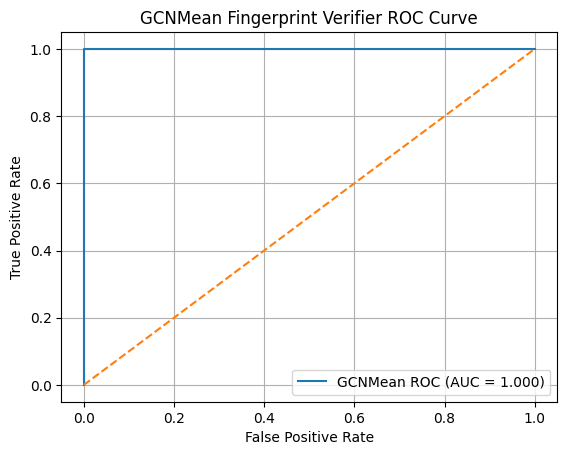

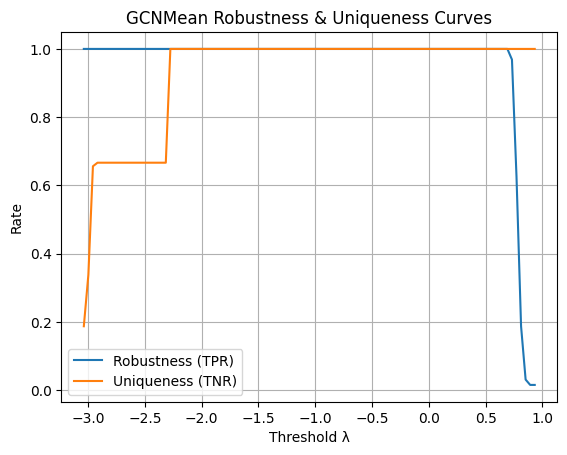

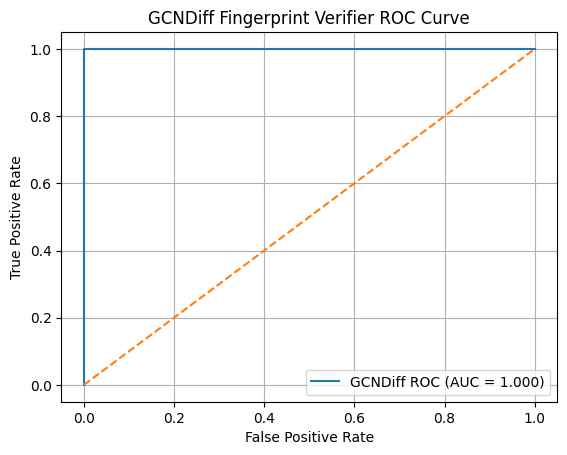

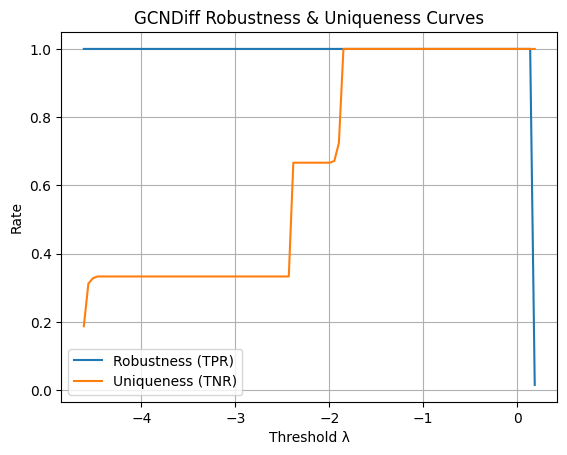

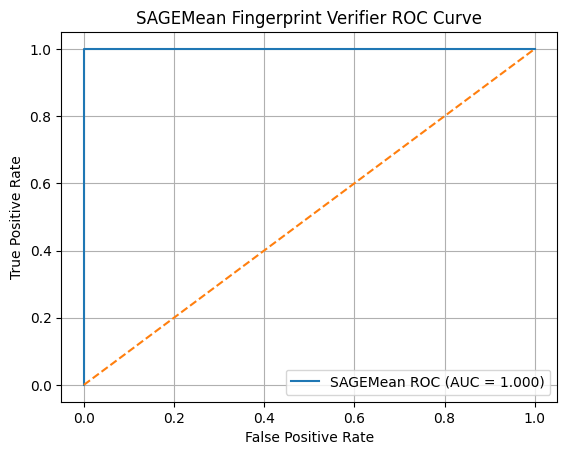

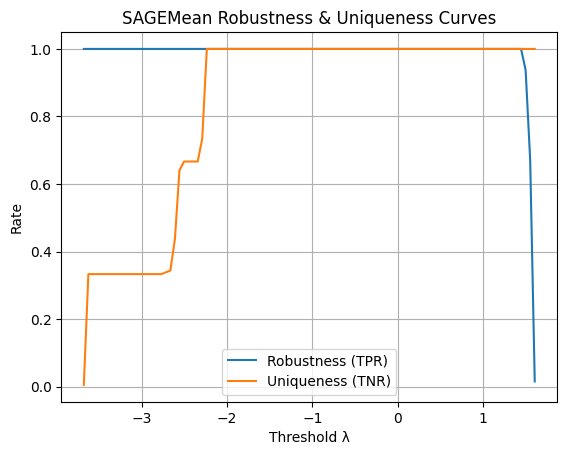

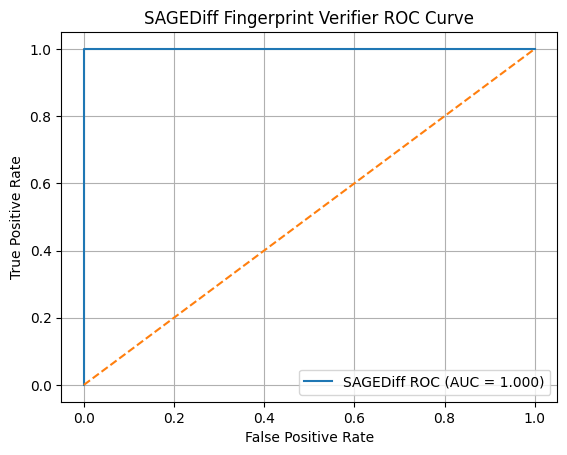

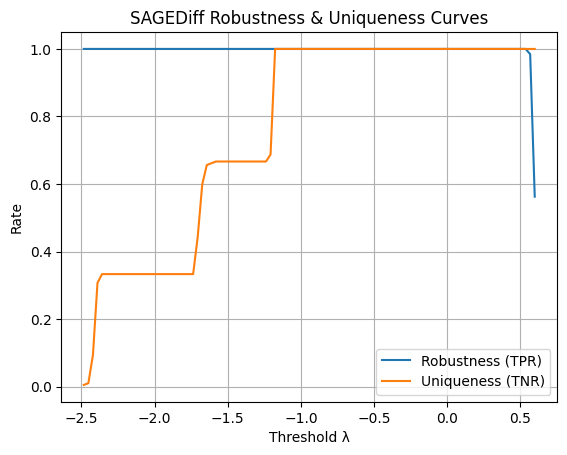

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

# === Mount Google Drive ===
drive.mount('/content/drive', force_remount=True)

# === Force CPU to avoid CUDA errors ===
device = torch.device('cpu')

# === Paths ===
FP_DIR   = '/content/drive/MyDrive/gnnfingers/fingerprints'
CKPT_DIR = '/content/drive/MyDrive/gnnfingers/checkpoints'

# === Reload victim models ===
victims = {}
for name, Cls in VariantCls.items():
    model = Cls(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, 0.5).to(device)
    ckpt = torch.load(f"{CKPT_DIR}/victim_ENZ_{name}.pth", map_location=device)
    model.load_state_dict(ckpt)
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    victims[name] = model

# === Load fingerprints ===
fps = []
for fn in sorted(os.listdir(FP_DIR)):
    raw = torch.load(os.path.join(FP_DIR, fn), map_location=device, weights_only=False)
    x = torch.nan_to_num(raw.x, nan=0.0, posinf=0.0, neginf=0.0)
    data = Data(x=x, edge_index=raw.edge_index)
    data.batch = torch.zeros(x.size(0), dtype=torch.long)
    fps.append(data)

# === Prepare storage ===
all_scores = {}
all_labels = {}
arucs = {}
variant_names = list(VariantCls.keys())

# === Compute inverted‐margin scores & ARUC ===
for name in variant_names:
    margins = []
    neg_scores = []

    # compute positive margins and collect negatives
    for d in fps:
        # true‐model log‐prob
        lp_v = F.log_softmax(victims[name](d.x, d.edge_index, d.batch), dim=1)[0, variant_names.index(name)]
        other_lps = []
        for other in variant_names:
            if other == name:
                continue
            lp_o = F.log_softmax(victims[other](d.x, d.edge_index, d.batch), dim=1)[0, variant_names.index(name)]
            other_lps.append(lp_o)
            neg_scores.append(-lp_o.item())

        max_other_lp = torch.stack(other_lps).max()
        margins.append((lp_v - max_other_lp).item())

    # invert so high⇒positive
    pos_scores = [-m for m in margins]
    neg_scores = [-s for s in neg_scores]

    labels = [1]*len(pos_scores) + [0]*len(neg_scores)
    scores = pos_scores + neg_scores

    # compute ARUC
    aruc = roc_auc_score(labels, scores)
    arucs[name] = aruc
    all_scores[name] = np.array(scores)
    all_labels[name] = np.array(labels)

# === Print ARUC table ===
print("Variant\tARUC")
print("-------\t-----")
for name, v in arucs.items():
    print(f"{name}\t{v:.4f}")

# === Plot ROC & Robustness/Uniqueness ===
for name in variant_names:
    scores = all_scores[name]
    labels = all_labels[name]

    # ROC
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} ROC (AUC = {roc_auc:.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.title(f'{name} Fingerprint Verifier ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Robustness & Uniqueness
    th_vals = np.linspace(scores.min(), scores.max(), 100)
    robustness = [np.mean(scores[labels==1] >= t) for t in th_vals]
    uniqueness = [np.mean(scores[labels==0] <= t) for t in th_vals]

    plt.figure()
    plt.plot(th_vals, robustness, label='Robustness (TPR)')
    plt.plot(th_vals, uniqueness, label='Uniqueness (TNR)')
    plt.title(f'{name} Robustness & Uniqueness Curves')
    plt.xlabel('Threshold λ')
    plt.ylabel('Rate')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
